# Growth Curve Analysis

In [11]:
import growthcurves as gc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 

gc.__version__

'0.1.dev8+g69f50497c.d20260127'

In [12]:
data = [
0.0493, 0.0494, 0.0492, 0.0491, 0.0491, 0.0492, 0.0492, 0.0490, 0.0491, 0.0491,
0.0492, 0.0490, 0.0492, 0.0490, 0.0490, 0.0489, 0.0491, 0.0491, 0.0491, 0.0491,
0.0491, 0.0491, 0.0492, 0.0491, 0.0492, 0.0492, 0.0492, 0.0493, 0.0492, 0.0493,
0.0495, 0.0494, 0.0494, 0.0494, 0.0494, 0.0494, 0.0495, 0.0494, 0.0495, 0.0497,
0.0496, 0.0496, 0.0498, 0.0497, 0.0498, 0.0498, 0.0498, 0.0499, 0.0500, 0.0499,
0.0501, 0.0499, 0.0501, 0.0500, 0.0499, 0.0502, 0.0502, 0.0503, 0.0502, 0.0503,
0.0503, 0.0503, 0.0504, 0.0503, 0.0504, 0.0506, 0.0506, 0.0506, 0.0506, 0.0507,
0.0508, 0.0509, 0.0509, 0.0509, 0.0510, 0.0510, 0.0510, 0.0512, 0.0512, 0.0513,
0.0514, 0.0513, 0.0514, 0.0515, 0.0515, 0.0516, 0.0515, 0.0518, 0.0518, 0.0518,
0.0520, 0.0519, 0.0520, 0.0522, 0.0521, 0.0522, 0.0523, 0.0523, 0.0525, 0.0526,
0.0527, 0.0528, 0.0528, 0.0527, 0.0530, 0.0531, 0.0531, 0.0532, 0.0534, 0.0533,
0.0535, 0.0534, 0.0537, 0.0537, 0.0540, 0.0539, 0.0540, 0.0540, 0.0543, 0.0544,
0.0545, 0.0546, 0.0547, 0.0549, 0.0549, 0.0551, 0.0552, 0.0553, 0.0554, 0.0555,
0.0557, 0.0557, 0.0559, 0.0560, 0.0560, 0.0564, 0.0565, 0.0567, 0.0567, 0.0570,
0.0571, 0.0574, 0.0575, 0.0576, 0.0579, 0.0581, 0.0582, 0.0583, 0.0585, 0.0588,
0.0591, 0.0592, 0.0594, 0.0598, 0.0600, 0.0602, 0.0606, 0.0610, 0.0613, 0.0616,
0.0620, 0.0624, 0.0627, 0.0633, 0.0638, 0.0643, 0.0649, 0.0655, 0.0659, 0.0666,
0.0672, 0.0679, 0.0685, 0.0695, 0.0703, 0.0712, 0.0722, 0.0732, 0.0741, 0.0754,
0.0766, 0.0780, 0.0792, 0.0806, 0.0821, 0.0834, 0.0853, 0.0867, 0.0885, 0.0900,
0.0920, 0.0941, 0.0962, 0.0982, 0.1002, 0.1024, 0.1044, 0.1063, 0.1078, 0.1100,
0.1120, 0.1141, 0.1163, 0.1188, 0.1214, 0.1238, 0.1262, 0.1290, 0.1319, 0.1346,
0.1376, 0.1407, 0.1438, 0.1468, 0.1502, 0.1538, 0.1576, 0.1615, 0.1653, 0.1694,
0.1735, 0.1783, 0.1834, 0.1895, 0.1949, 0.2008, 0.2072, 0.2128, 0.2194, 0.2255,
0.2321, 0.2386, 0.2451, 0.2523, 0.2590, 0.2647, 0.2700, 0.2752, 0.2812, 0.2866,
0.2920, 0.2969, 0.3022, 0.3081, 0.3130, 0.3187, 0.3233, 0.3280, 0.3328, 0.3363,
0.3409, 0.3451, 0.3486, 0.3532, 0.3570, 0.3599, 0.3634, 0.3670, 0.3703, 0.3736,
0.3773, 0.3806, 0.3845, 0.3882, 0.3933, 0.3992, 0.4032, 0.4068, 0.4108, 0.4146,
0.4177, 0.4201, 0.4236, 0.4263, 0.4288, 0.4322, 0.4347, 0.4373, 0.4394, 0.4412,
0.4426, 0.4440, 0.4461, 0.4481, 0.4487, 0.4500, 0.4514, 0.4522, 0.4534, 0.4532,
0.4541, 0.4545, 0.4552, 0.4553, 0.4557, 0.4566, 0.4561, 0.4571, 0.4579, 0.4579,
0.4588, 0.4587, 0.4600, 0.4595, 0.4601, 0.4596, 0.4597, 0.4601, 0.4603, 0.4598,
0.4596, 0.4597, 0.4595, 0.4600, 0.4607, 0.4606, 0.4606, 0.4601, 0.4605, 0.4602,
0.4650, 0.4646, 0.4637, 0.4622, 0.4609, 0.4605, 0.4601, 0.4597, 0.4605, 0.4600,
0.4598, 0.4600, 0.4604, 0.4602, 0.4605, 0.4606, 0.4611, 0.4604, 0.4605, 0.4609,
0.4604, 0.4615, 0.4613, 0.4615, 0.4615, 0.4616, 0.4616, 0.4617, 0.4622, 0.4624,
0.4621, 0.4621, 0.4625, 0.4626, 0.4625, 0.4626, 0.4627, 0.4623, 0.4628, 0.4628,
0.4625, 0.4633, 0.4632, 0.4632, 0.4641, 0.4644, 0.4645, 0.4645, 0.4646, 0.4652,
0.4661, 0.4659, 0.4662, 0.4666, 0.4661, 0.4673, 0.4675, 0.4678, 0.4674, 0.4683,
0.4683, 0.4684, 0.4693, 0.4697, 0.4697, 0.4702, 0.4699, 0.4701, 0.4715, 0.4716,
0.4718, 0.4723, 0.4724, 0.4724, 0.4734, 0.4730, 0.4734, 0.4744, 0.4738, 0.4745,
0.4750, 0.4758, 0.4762, 0.4764, 0.4766, 0.4771, 0.4775, 0.4777, 0.4784, 0.4783,
0.4787, 0.4796, 0.4800, 0.4805, 0.4812, 0.4817, 0.4825, 0.4826, 0.4826, 0.4833,
0.4837, 0.4843, 0.4842, 0.4844, 0.4851, 0.4860, 0.4867, 0.4864, 0.4872, 0.4876,
0.4880, 0.4889, 0.4896, 0.4893, 0.4901, 0.4906, 0.4907, 0.4913, 0.4920, 0.4926,
0.4929, 0.4926, 0.4932, 0.4940, 0.4943, 0.4949, 0.4955, 0.4957, 0.4960, 0.4968,
0.4972, 0.4982, 0.4982, 0.4988, 0.4989, 0.4999, 0.5000, 0.5006, 0.5012, 0.5013,
0.5016, 0.5017, 0.5027, 0.5023, 0.5034, 0.5034, 0.5043, 0.5039, 0.5055, 0.5053,
0.5064, 0.5065, 0.5067, 0.5070, 0.5075, 0.5083, 0.5090, 0.5091, 0.5098, 0.5097,
0.5100, 0.5109, 0.5103, 0.5110, 0.5122, 0.5123, 0.5131, 0.5129, 0.5130, 0.5139,
0.5140, 0.5144, 0.5157, 0.5158, 0.5162, 0.5172, 0.5171, 0.5170, 0.5174, 0.5190,
0.5186, 0.5193, 0.5195, 0.5203, 0.5202, 0.5211, 0.5212, 0.5224, 0.5224, 0.5227,
0.5229, 0.5247, 0.5246, 0.5251, 0.5255, 0.5262, 0.5270, 0.5273, 0.5273, 0.5279,
0.5289, 0.5290, 0.5288, 0.5298, 0.5305, 0.5309, 0.5309, 0.5319, 0.5322, 0.5325,
0.5331, 0.5337, 0.5342, 0.5344, 0.5347, 0.5359, 0.5364, 0.5361, 0.5372, 0.5372,
0.5378, 0.5381, 0.5383, 0.5389, 0.5396, 0.5401, 0.5405, 0.5400, 0.5408, 0.5417,
0.5424, 0.5447, 0.5473, 0.5485, 0.5501, 0.5499, 0.5494, 0.5493, 0.5489, 0.5486,
0.5480, 0.5475, 0.5472, 0.5475, 0.5471, 0.5464, 0.5462, 0.5457, 0.5457, 0.5452,
0.5456, 0.5455, 0.5453, 0.5445, 0.5451, 0.5457, 0.5449, 0.5447, 0.5448, 0.5453,
0.5452, 0.5450, 0.5444, 0.5444, 0.5450, 0.5451, 0.5452, 0.5444, 0.5454, 0.5455,
0.5454, 0.5456, 0.5461, 0.5466, 0.5467, 0.5468, 0.5473, 0.5471, 0.5478, 0.5476,
0.5476, 0.5483, 0.5486, 0.5493, 0.5485, 0.5488, 0.5490, 0.5503, 0.5496, 0.5497,
0.5502, 0.5502, 0.5503, 0.5500, 0.5505, 0.5504, 0.5512, 0.5514, 0.5507, 0.5512,
0.5513, 0.5517, 0.5519, 0.5519, 0.5517, 0.5523, 0.5526, 0.5522, 0.5518, 0.5527,
0.5522, 0.5525, 0.5527, 0.5529, 0.5533, 0.5532, 0.5537, 0.5533, 0.5538, 0.5540,
0.5538, 0.5538, 0.5541, 0.5541, 0.5541, 0.5545, 0.5541, 0.5550, 0.5549, 0.5555,
0.5552, 0.5552, 0.5556, 0.5554, 0.5552, 0.5560, 0.5561, 0.5558, 0.5564, 0.5567,
0.5559, 0.5567, 0.5566, 0.5566, 0.5567, 0.5560, 0.5571, 0.5568, 0.5572, 0.5569,
0.5576, 0.5580, 0.5578, 0.5575, 0.5581, 0.5583, 0.5577, 0.5578, 0.5581, 0.5586,
0.5590, 0.5586, 0.5594, 0.5598, 0.5591, 0.5597, 0.5598, 0.5602, 0.5601, 0.5604,
0.5602, 0.5603, 0.5606, 0.5608
]

time = [(12*n)/60 for n in range(len(data))] # time in hours

In [ ]:
# Fit using each parametric model type
logistic_result = gc.parametric_fitting.fit_model(time, data, model_type="logistic")
gompertz_result = gc.parametric_fitting.fit_model(time, data, model_type="gompertz")
richards_result = gc.parametric_fitting.fit_model(time, data, model_type="richards")

# Get growth stats from the fitted model objects
logistic_stats = gc.parametric_fitting.extract_stats_from_fit(logistic_result)
gompertz_stats = gc.parametric_fitting.extract_stats_from_fit(gompertz_result)
richards_stats = gc.parametric_fitting.extract_stats_from_fit(richards_result)

# Fit using non-parametric methods via the new fit_parametric API
# Method 1: Sliding Window (finds max slope in log-transformed windows)
sliding_window_stats = gc.non_parametric_fitting.fit_parametric(
    time, data, umax_method="sliding_window"
)

# Method 2: Spline (fits spline to exponential phase, calculates derivative)
spline_stats = gc.non_parametric_fitting.fit_parametric(
    time, data, umax_method="spline"
)

## Visualize Fitted Growth Curve Models

The fitted model results contain the optimized parameters for each growth curve model.

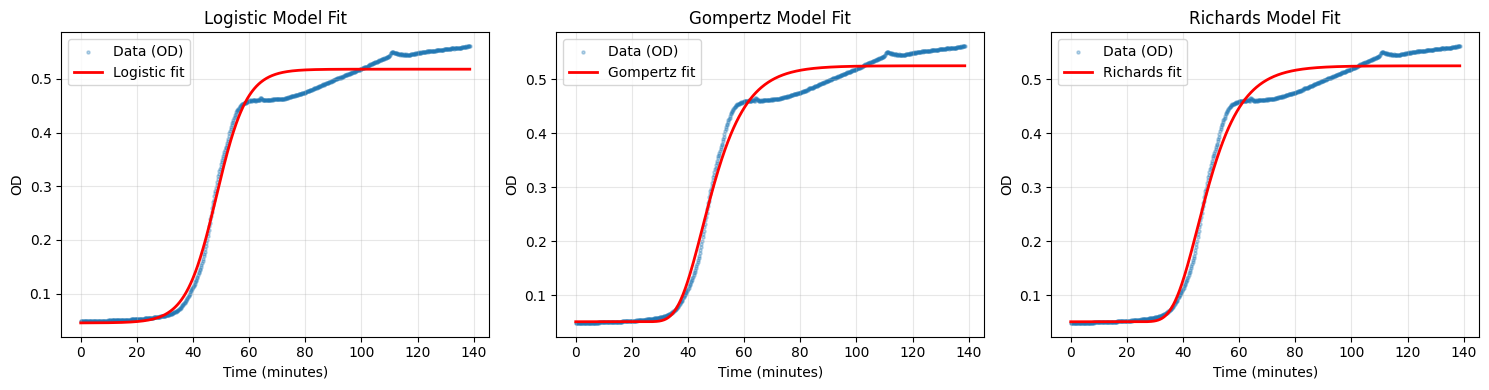

In [14]:
# Plot data with fitted curves
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Convert data to arrays for plotting
t_arr = np.array(time)
y_arr = np.array(data)

models = [
    ("Logistic", logistic_result, logistic_stats),
    ("Gompertz", gompertz_result, gompertz_stats),
    ("Richards", richards_result, richards_stats),
]

for ax, (name, result, stats) in zip(axes, models):
    # Plot raw data
    ax.scatter(t_arr, y_arr, alpha=0.3, s=5, label="Data (OD)")
    
    if result is not None:
        # Shade exponential phase region from growth stats
        lag_end = stats.get("lag_phase_end")
        exp_end = stats.get("exponential_phase_end")
        if lag_end is not None and exp_end is not None and np.isfinite(lag_end) and np.isfinite(exp_end):
            ax.axvspan(lag_end, exp_end, alpha=0.3, color='green', label='Exponential phase')
        
        # Plot fitted curve in linear OD space
        ax.plot(result["t"], result["y_fit"], 'r-', linewidth=2, label=f"{name} fit")
    
    ax.set_xlabel("Time (minutes)")
    ax.set_ylabel("OD")
    ax.set_title(f"{name} Model Fit")
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

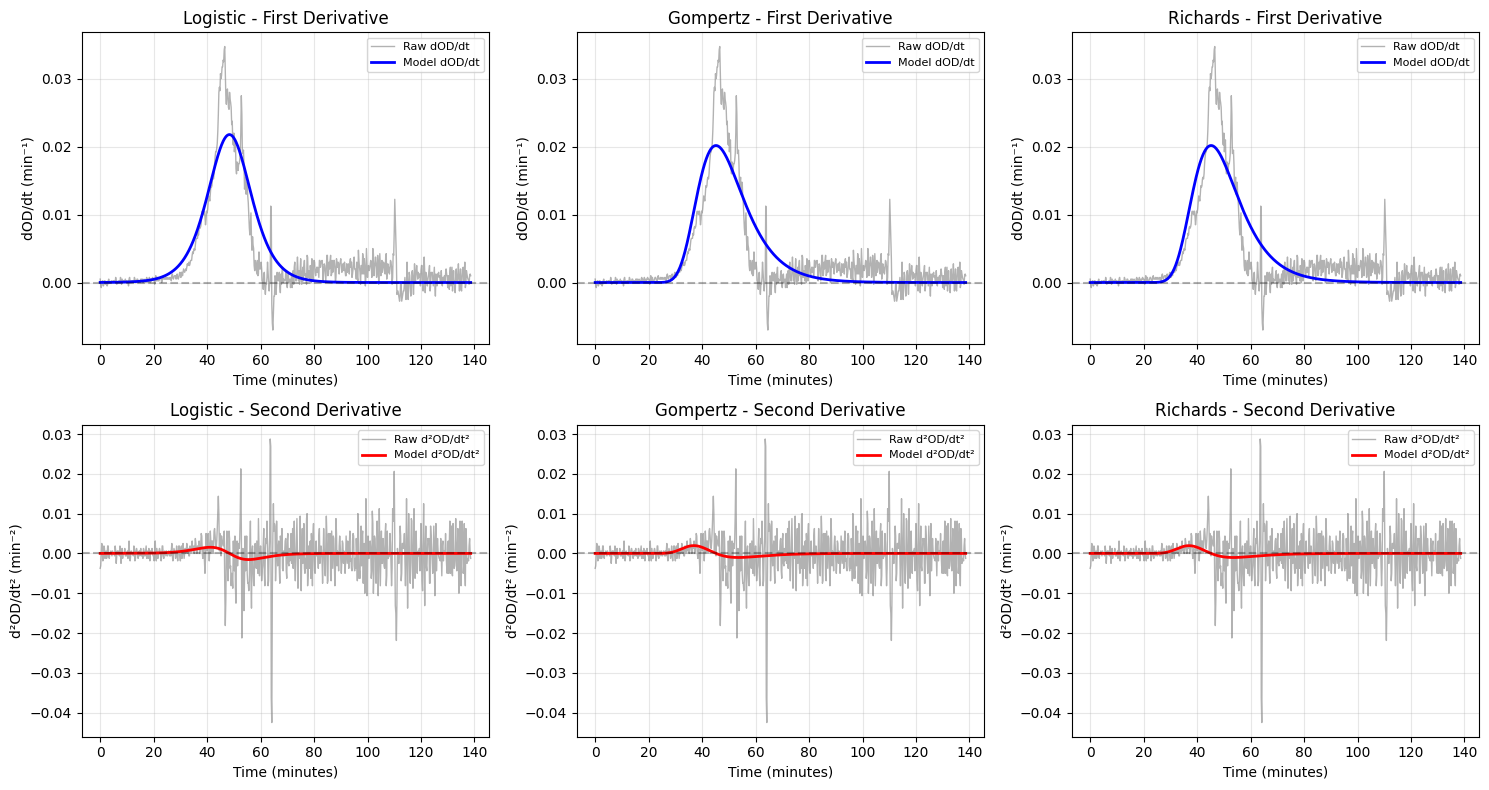

In [15]:
# Plot first and second derivatives of each model using package functions
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Convert data to arrays for raw-derivative overlay
raw_t = np.array(time)
raw_y = np.array(data)
raw_dy_dt = gc.utils.first_derivative(raw_t, raw_y)
raw_d2y_dt2 = gc.utils.second_derivative(raw_t, raw_y)

models = [
    ("Logistic", logistic_result),
    ("Gompertz", gompertz_result),
    ("Richards", richards_result),
]

for col, (name, result) in enumerate(models):
    if result is None:
        continue

    t = result["t"]
    y_fit = result["y_fit"]

    # Calculate derivatives using package functions
    dy_dt = gc.utils.first_derivative(t, y_fit)
    d2y_dt2 = gc.utils.second_derivative(t, y_fit)

    # Plot first derivative
    ax1 = axes[0, col]
    ax1.plot(raw_t, raw_dy_dt, color="gray", linewidth=1, alpha=0.6, label="Raw dOD/dt")
    ax1.plot(t, dy_dt, 'b-', linewidth=2, label="Model dOD/dt")
    ax1.set_xlabel("Time (minutes)")
    ax1.set_ylabel("dOD/dt (min⁻¹)")
    ax1.set_title(f"{name} - First Derivative")
    ax1.grid(True, alpha=0.3)
    ax1.axhline(y=0, color='k', linestyle='--', alpha=0.3)
    ax1.legend(fontsize=8)

    # Plot second derivative
    ax2 = axes[1, col]
    ax2.plot(raw_t, raw_d2y_dt2, color="gray", linewidth=1, alpha=0.6, label="Raw d²OD/dt²")
    ax2.plot(t, d2y_dt2, 'r-', linewidth=2, label="Model d²OD/dt²")
    ax2.set_xlabel("Time (minutes)")
    ax2.set_ylabel("d²OD/dt² (min⁻²)")
    ax2.set_title(f"{name} - Second Derivative")
    ax2.grid(True, alpha=0.3)
    ax2.axhline(y=0, color='k', linestyle='--', alpha=0.3)
    ax2.legend(fontsize=8)

plt.tight_layout()
plt.show()


## Extracting Model Parameters

The fitted model results contain the optimized parameters for each growth curve model.

In [16]:
# Extract parameters from logistic model
print("Logistic Model Parameters:")
print(f"  Model type: {logistic_result['model_type']}")
print(f"  Fitted parameters: {logistic_result['params']}")
print(f"    K (carrying capacity): {logistic_result['params']['K']:.4f}")
print(f"    y0 (baseline OD): {logistic_result['params']['y0']:.4f}")
print(f"    r (growth rate): {logistic_result['params']['r']:.4f}")
print(f"    t0 (inflection time): {logistic_result['params']['t0']:.2f}")
print()

# Extract parameters from Gompertz model
print("Gompertz Model Parameters:")
print(f"  Model type: {gompertz_result['model_type']}")
print(f"  Fitted parameters: {gompertz_result['params']}")
print(f"    K (carrying capacity): {gompertz_result['params']['K']:.4f}")
print(f"    y0 (baseline OD): {gompertz_result['params']['y0']:.4f}")
print(f"    mu_max (growth rate): {gompertz_result['params']['mu_max_param']:.4f}")
print(f"    lam (lag time): {gompertz_result['params']['lam']:.2f}")
print()

# Extract parameters from Richards model
print("Richards Model Parameters:")
print(f"  Model type: {richards_result['model_type']}")
print(f"  Fitted parameters: {richards_result['params']}")
print(f"    K (carrying capacity): {richards_result['params']['K']:.4f}")
print(f"    y0 (baseline OD): {richards_result['params']['y0']:.4f}")
print(f"    r (growth rate): {richards_result['params']['r']:.4f}")
print(f"    t0 (inflection time): {richards_result['params']['t0']:.2f}")
print(f"    nu (shape parameter): {richards_result['params']['nu']:.4f}")
print()

# Access growth statistics extracted via extract_stats_from_fit
print("Logistic Growth Statistics:")
for key, value in logistic_stats.items():
    print(f"  {key}: {value}")
print()

print("Gompertz Growth Statistics:")
for key, value in gompertz_stats.items():
    print(f"  {key}: {value}")

Logistic Model Parameters:
  Model type: logistic
  Fitted parameters: {'K': np.float64(0.5179477199372282), 'y0': np.float64(0.0454790298563513), 'r': np.float64(0.184455480980883), 't0': np.float64(48.346737932212086)}
    K (carrying capacity): 0.5179
    y0 (baseline OD): 0.0455
    r (growth rate): 0.1845
    t0 (inflection time): 48.35

Gompertz Model Parameters:
  Model type: gompertz
  Fitted parameters: {'K': np.float64(0.5245286195029899), 'y0': np.float64(0.05103740537395796), 'mu_max_param': np.float64(0.020172534003075532), 'lam': np.float64(36.5530438012088)}
    K (carrying capacity): 0.5245
    y0 (baseline OD): 0.0510
    mu_max (growth rate): 0.0202
    lam (lag time): 36.55

Richards Model Parameters:
  Model type: richards
  Fitted parameters: {'K': np.float64(0.524437849172164), 'y0': np.float64(0.05098158007104342), 'r': np.float64(0.1164106413105543), 't0': np.float64(45.23380260462562), 'nu': np.float64(0.010000000000000002)}
    K (carrying capacity): 0.5244
  

## Comparing Calculated Growth Parameters

We can compare the calculated growth statistics across different models.

In [ ]:
# Extract key growth parameters from each model
comparison_data = {
    'Model': ['Logistic', 'Gompertz', 'Richards', 'Sliding Window', 'Spline'],
    'Max OD': [
        logistic_stats['max_od'],
        gompertz_stats['max_od'],
        richards_stats['max_od'],
        sliding_window_stats['max_od'],
        spline_stats['max_od']
    ],
    'μmax (h⁻¹)': [
        logistic_stats['specific_growth_rate'],
        gompertz_stats['specific_growth_rate'],
        richards_stats['specific_growth_rate'],
        sliding_window_stats['specific_growth_rate'],
        spline_stats['specific_growth_rate']
    ],
    'Doubling Time (h)': [
        logistic_stats['doubling_time'],
        gompertz_stats['doubling_time'],
        richards_stats['doubling_time'],
        sliding_window_stats['doubling_time'],
        spline_stats['doubling_time']
    ],
    'Lag Phase End (h)': [
        logistic_stats['exp_phase_start'],
        gompertz_stats['exp_phase_start'],
        richards_stats['exp_phase_start'],
        sliding_window_stats['exp_phase_start'],
        spline_stats['exp_phase_start']
    ],
    'Exp Phase End (h)': [
        logistic_stats['exp_phase_end'],
        gompertz_stats['exp_phase_end'],
        richards_stats['exp_phase_end'],
        sliding_window_stats['exp_phase_end'],
        spline_stats['exp_phase_end']
    ],
    'RMSE': [
        logistic_stats['model_rmse'],
        gompertz_stats['model_rmse'],
        richards_stats['model_rmse'],
        sliding_window_stats['model_rmse'],
        spline_stats['model_rmse']
    ]
}

# Create a DataFrame for easy viewing
df = pd.DataFrame(comparison_data)
df = df.round(4)  # Round to 4 decimal places
print("Growth Parameters Comparison Table:")
print("Parametric models: Logistic, Gompertz, Richards")
print("Non-parametric methods: Sliding Window, Spline")
df

In [ ]:
# Create bar graphs for visual comparison
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Growth Parameters Comparison Across Models', fontsize=16, fontweight='bold')

models = df['Model']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# Plot 1: Max OD
axes[0, 0].bar(models, df['Max OD'], color=colors, edgecolor="black")
axes[0, 0].set_title('Maximum OD')
axes[0, 0].set_ylabel('OD')
axes[0, 0].tick_params(axis='x', rotation=45)

# Plot 2: Specific Growth Rate (μmax)
axes[0, 1].bar(models, df['μmax (h⁻¹)'], color=colors, edgecolor="black")
axes[0, 1].set_title('Maximum Specific Growth Rate (μmax)')
axes[0, 1].set_ylabel('μmax (h⁻¹)')
axes[0, 1].tick_params(axis='x', rotation=45)

# Plot 3: Doubling Time
axes[0, 2].bar(models, df['Doubling Time (h)'], color=colors, edgecolor="black")
axes[0, 2].set_title('Doubling Time')
axes[0, 2].set_ylabel('Time (h)')
axes[0, 2].tick_params(axis='x', rotation=45)

# Plot 4: Lag Phase End
axes[1, 0].bar(models, df['Lag Phase End (h)'], color=colors, edgecolor="black")
axes[1, 0].set_title('Lag Phase End Time')
axes[1, 0].set_ylabel('Time (h)')
axes[1, 0].tick_params(axis='x', rotation=45)

# Plot 5: Exponential Phase End
axes[1, 1].bar(models, df['Exp Phase End (h)'], color=colors, edgecolor="black")
axes[1, 1].set_title('Exponential Phase End Time')
axes[1, 1].set_ylabel('Time (h)')
axes[1, 1].tick_params(axis='x', rotation=45)

# Plot 6: RMSE
axes[1, 2].bar(models, df['RMSE'], color=colors, edgecolor="black")
axes[1, 2].set_title('Model Fit Quality (RMSE)')
axes[1, 2].set_ylabel('RMSE')
axes[1, 2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Quick-Start: Synthetic Logistic Example

A minimal end-to-end example using synthetic data.

## Non-Parametric Fitting Methods

The `fit_parametric` function is the main API for non-parametric growth curve analysis. It supports two methods for calculating maximum specific growth rate (Umax):

### Method 1: Sliding Window
Finds the maximum slope by fitting lines to log-transformed OD data in consecutive windows. The window with the steepest slope gives the maximum specific growth rate.

### Method 2: Spline
Identifies the exponential growth phase, fits a smoothing spline to that region, and calculates Umax from the spline's derivative. This method is particularly useful for noisy data or irregular sampling.

In [ ]:
# Demonstrate both non-parametric methods with visual comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot data
t_arr = np.array(time)
y_arr = np.array(data)

methods = [
    ("Sliding Window", sliding_window_stats),
    ("Spline", spline_stats)
]

for ax, (name, stats) in zip(axes, methods):
    # Plot raw data
    ax.scatter(t_arr, y_arr, alpha=0.3, s=5, label="Data (OD)", color='gray')
    
    # Shade exponential phase
    exp_start = stats.get("exp_phase_start")
    exp_end = stats.get("exp_phase_end")
    if exp_start is not None and exp_end is not None and np.isfinite(exp_start) and np.isfinite(exp_end):
        ax.axvspan(exp_start, exp_end, alpha=0.3, color='lightgreen', label='Exponential phase')
    
    # Mark time at Umax
    time_umax = stats.get("time_at_umax")
    od_umax = stats.get("od_at_umax")
    if time_umax is not None and od_umax is not None:
        ax.axvline(time_umax, color='red', linestyle='--', linewidth=2, alpha=0.7, label=f'Umax at t={time_umax:.1f}h')
        ax.plot(time_umax, od_umax, 'r*', markersize=15, label=f'μmax={stats["specific_growth_rate"]:.3f} h⁻¹')
    
    ax.set_xlabel("Time (hours)")
    ax.set_ylabel("OD")
    ax.set_title(f"{name} Method\nDoubling time: {stats['doubling_time']:.2f}h")
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print comparison
print(f"\n{'Method':<20} {'μmax (h⁻¹)':<15} {'Doubling Time (h)':<20} {'RMSE':<10}")
print("-" * 65)
print(f"{'Sliding Window':<20} {sliding_window_stats['specific_growth_rate']:<15.4f} {sliding_window_stats['doubling_time']:<20.2f} {sliding_window_stats['model_rmse']:<10.4f}")
print(f"{'Spline':<20} {spline_stats['specific_growth_rate']:<15.4f} {spline_stats['doubling_time']:<20.2f} {spline_stats['model_rmse']:<10.4f}")

In [ ]:
# Create comprehensive visualization of non-parametric fitting methods
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

t_arr = np.array(time)
y_arr = np.array(data)

# Calculate log-transformed data for visualization
log_y = np.log(y_arr)

methods = [
    ("Sliding Window", sliding_window_stats),
    ("Spline", spline_stats)
]

for col, (name, stats) in enumerate(methods):
    # Top row: Linear scale OD vs time
    ax_linear = axes[0, col]
    ax_linear.scatter(t_arr, y_arr, alpha=0.3, s=5, label="Data (OD)", color='gray')
    
    # Shade exponential phase
    exp_start = stats.get("exp_phase_start")
    exp_end = stats.get("exp_phase_end")
    if exp_start is not None and exp_end is not None and np.isfinite(exp_start) and np.isfinite(exp_end):
        ax_linear.axvspan(exp_start, exp_end, alpha=0.25, color='lightgreen', label='Exponential phase')
    
    # Mark time at Umax with larger marker
    time_umax = stats.get("time_at_umax")
    od_umax = stats.get("od_at_umax")
    if time_umax is not None and od_umax is not None:
        ax_linear.plot(time_umax, od_umax, 'r*', markersize=20, 
                      label=f'μmax = {stats["specific_growth_rate"]:.3f} h⁻¹', zorder=5)
        ax_linear.axvline(time_umax, color='red', linestyle='--', linewidth=1, alpha=0.5)
    
    ax_linear.set_xlabel("Time (hours)", fontsize=10)
    ax_linear.set_ylabel("OD", fontsize=10)
    ax_linear.set_title(f"{name} Method - Linear Scale", fontsize=11, fontweight='bold')
    ax_linear.legend(fontsize=8)
    ax_linear.grid(True, alpha=0.3)
    
    # Bottom row: Log scale ln(OD) vs time
    ax_log = axes[1, col]
    ax_log.scatter(t_arr, log_y, alpha=0.3, s=5, label="ln(OD)", color='gray')
    
    # Shade exponential phase in log scale too
    if exp_start is not None and exp_end is not None and np.isfinite(exp_start) and np.isfinite(exp_end):
        ax_log.axvspan(exp_start, exp_end, alpha=0.25, color='lightgreen', label='Exponential phase')
        
        # Draw a line through the exponential phase to show the linear fit
        # The slope of this line is the specific growth rate (μmax)
        exp_mask = (t_arr >= exp_start) & (t_arr <= exp_end)
        if np.sum(exp_mask) > 1:
            t_exp = t_arr[exp_mask]
            # Calculate fitted line: ln(OD) = ln(OD0) + μmax * t
            slope = stats["specific_growth_rate"]
            # Use the point at time_umax as reference
            if time_umax is not None and od_umax is not None:
                intercept = np.log(od_umax) - slope * time_umax
                fitted_line = intercept + slope * t_exp
                ax_log.plot(t_exp, fitted_line, 'r-', linewidth=2, 
                           label=f'Linear fit (slope = μmax)', zorder=4)
    
    # Mark time at Umax in log scale
    if time_umax is not None and od_umax is not None:
        ax_log.plot(time_umax, np.log(od_umax), 'r*', markersize=20, zorder=5)
        ax_log.axvline(time_umax, color='red', linestyle='--', linewidth=1, alpha=0.5)
    
    ax_log.set_xlabel("Time (hours)", fontsize=10)
    ax_log.set_ylabel("ln(OD)", fontsize=10)
    ax_log.set_title(f"{name} Method - Log Scale", fontsize=11, fontweight='bold')
    ax_log.legend(fontsize=8)
    ax_log.grid(True, alpha=0.3)

fig.suptitle('Non-Parametric Growth Curve Analysis', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

# Print detailed comparison
print(f"\n{'='*80}")
print(f"{'NON-PARAMETRIC METHODS COMPARISON':^80}")
print(f"{'='*80}")
print(f"\n{'Parameter':<30} {'Sliding Window':<25} {'Spline':<25}")
print(f"{'-'*80}")
print(f"{'Max OD:':<30} {sliding_window_stats['max_od']:<25.4f} {spline_stats['max_od']:<25.4f}")
print(f"{'μmax (h⁻¹):':<30} {sliding_window_stats['specific_growth_rate']:<25.4f} {spline_stats['specific_growth_rate']:<25.4f}")
print(f"{'Doubling time (h):':<30} {sliding_window_stats['doubling_time']:<25.2f} {spline_stats['doubling_time']:<25.2f}")
print(f"{'Lag phase end (h):':<30} {sliding_window_stats['exp_phase_start']:<25.2f} {spline_stats['exp_phase_start']:<25.2f}")
print(f"{'Exp phase end (h):':<30} {sliding_window_stats['exp_phase_end']:<25.2f} {spline_stats['exp_phase_end']:<25.2f}")
print(f"{'Time at μmax (h):':<30} {sliding_window_stats['time_at_umax']:<25.2f} {spline_stats['time_at_umax']:<25.2f}")
print(f"{'OD at μmax:':<30} {sliding_window_stats['od_at_umax']:<25.4f} {spline_stats['od_at_umax']:<25.4f}")
print(f"{'RMSE:':<30} {sliding_window_stats['model_rmse']:<25.4f} {spline_stats['model_rmse']:<25.4f}")
print(f"{'='*80}\n")

### API Usage

The `fit_parametric` function provides a unified interface for non-parametric growth curve analysis:

```python
# Using sliding window method
stats = gc.non_parametric_fitting.fit_parametric(
    t, y, 
    umax_method="sliding_window",
    window_points=15,        # Number of points per window
    sg_window=11,            # Savitzky-Golay smoothing window
    lag_frac=0.15,           # Fraction for lag phase detection
    exp_frac=0.15            # Fraction for exp phase detection
)

# Using spline method
stats = gc.non_parametric_fitting.fit_parametric(
    t, y,
    umax_method="spline",
    spline_s=None,           # Smoothing factor (None = automatic)
    sg_window=11,
    lag_frac=0.15,
    exp_frac=0.15
)
```

Both methods return the same dictionary structure with growth statistics including:
- `specific_growth_rate`: Maximum specific growth rate (μmax) in h⁻¹
- `doubling_time`: Doubling time calculated from μmax
- `exp_phase_start`: Time when exponential phase begins
- `exp_phase_end`: Time when exponential phase ends
- `time_at_umax`: Time at which μmax occurs
- `od_at_umax`: OD value at time of μmax
- `max_od`: Maximum OD reached
- `model_rmse`: Root mean square error

In [19]:
# Example time series (hours) and OD measurements
time_synth = np.linspace(0, 24, 100)
od_synth = 0.01 + 1.5 / (1 + np.exp(-0.5 * (time_synth - 10)))  # synthetic logistic data

# Fit a logistic model
logistic_fit_synth = gc.parametric_fitting.fit_model(time_synth, od_synth, model_type="logistic")

# Extract growth statistics from the fit
stats_synth = gc.parametric_fitting.extract_stats_from_fit(logistic_fit_synth)

print(f"Max OD:              {stats_synth['max_od']:.3f}")
print(f"Specific growth rate: {stats_synth['specific_growth_rate']:.4f} h⁻¹")
print(f"Doubling time:        {stats_synth['doubling_time']:.2f} h")

Max OD:              1.510
Specific growth rate: 0.4417 h⁻¹
Doubling time:        1.57 h


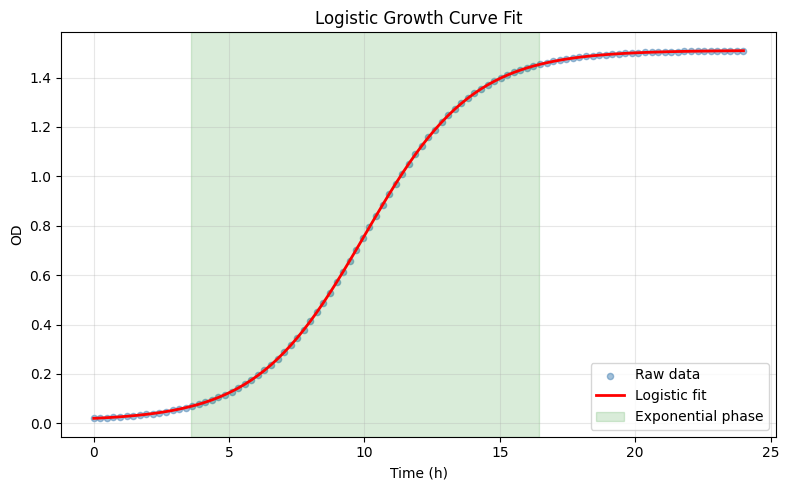

In [20]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.scatter(time_synth, od_synth, alpha=0.5, s=20, color="steelblue", label="Raw data")
ax.plot(logistic_fit_synth["t"], logistic_fit_synth["y_fit"], "r-", linewidth=2, label="Logistic fit")

# Shade exponential phase
exp_start = stats_synth.get("exp_phase_start")
exp_end = stats_synth.get("exp_phase_end")
if exp_start is not None and exp_end is not None:
    ax.axvspan(exp_start, exp_end, alpha=0.15, color="green", label="Exponential phase")

ax.set_xlabel("Time (h)")
ax.set_ylabel("OD")
ax.set_title("Logistic Growth Curve Fit")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()